# Algorithms Testing on Imbalanced Data

Student name: Jenny Nguyen

Student number: s223867709

Email address: s223867709@deakin.edu.au

Unit: SIT731 

## Introduction

Imbalanced datasets are a common challenge in machine learning, where the majority class significantly outnumbers the minority class. This imbalance problem often leads to biased models that perform poorly in predicting the minority class, which is usually the focus of analysis. To address this issue, various machine learning models and techniques have been implemented in working with imbalanced datasets.

In this report, we will focus on examining and comparing the performance of five models used with imbalanced data, which include Logistic Regression, Random Forest, SMOTE, Bagging, and Boosting — across varying levels of imbalance ratios (IR). The models are evaluated using three performance metrics: AUC (Area Under the ROC Curve), Kappa, and G-Mean. By comparing these metrics at different IR levels, this report aims to identify the most effective model for handling imbalanced datasets and provide actionable insights for model selection.

## Report

### Load necessary datasets

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, cohen_kappa_score
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import BalancedBaggingClassifier, RUSBoostClassifier
from imblearn.metrics import geometric_mean_score
from imblearn.over_sampling import SMOTE

### Create imbalance dataset

To examine the performance of machine learning models on different levels of imbalanced datasets, five datasets are created under different imbalanced ratio. Imbalanced ratio (IR) is defined as number of instances from the majority class divided by number of instances from the minority class (IR=Nmaj/Nmin).

Using imblearn library, new datasets, with 10,000 instances each, are created with the target label of either 0 or 1 (binary classification). Each dataset contains 10 dependent variables, with weights of each label depending on the value of imbalance ratio. The datasets are stored in a dictionary  for easy access.

In [3]:
imbalance_ratios = [5, 10, 20, 50, 100]

def generate_dataset(imbalance_ratio):
    X, y = make_classification(
        n_classes=2,
        weights=[1 - 1 / (imbalance_ratio + 1), 1 / (imbalance_ratio + 1)],
        n_informative=8,
        n_redundant=0,
        n_features=10,
        n_clusters_per_class=1,
        n_samples=10000,
        random_state=0
    )
    return pd.DataFrame(X, columns=['Feature 1','Feature 2','Feature 3','Feature 4','Feature 5','Feature 6','Feature 7','Feature 8','Feature 9','Feature 10']).assign(Label=y)
datasets = {}

for ratio in imbalance_ratios:
    datasets[f"ir_{ratio}"] = generate_dataset(ratio)


Now we will examine some datasets that we have created.

In [4]:
datasets['ir_5'].groupby('Label').count()

,Feature 1,Feature 2,Feature 3,Feature 4,Feature 5,Feature 6,Feature 7,Feature 8,Feature 9,Feature 10
Label,,,,,,,,,,
0,8320,8320,8320,8320,8320,8320,8320,8320,8320,8320
1,1680,1680,1680,1680,1680,1680,1680,1680,1680,1680


With ir_5 imbalance ratio is 5, as can be seen from the ratio between number of instances from label 0 divided by number of instances from label 1. 

In [5]:
datasets['ir_5'].head()

,Feature 1,Feature 2,Feature 3,Feature 4,Feature 5,Feature 6,Feature 7,Feature 8,Feature 9,Feature 10,Label
0,-0.816756,-0.636732,-1.888162,4.686583,-0.247396,-0.177157,-4.291875,-0.149812,-2.152043,0.107734,0
1,0.853570,0.626733,-3.386417,1.956908,0.001280,-0.192769,1.349594,-1.977490,-1.760126,-1.443405,0
2,1.585135,1.434930,-6.005278,-0.360666,-0.302661,5.999264,-1.068326,2.806965,-0.489226,-2.823990,0
3,2.010142,-0.941573,0.439136,1.081837,0.598070,1.808542,-0.258538,-0.774550,-0.252350,-1.613012,0
4,2.256378,-0.587937,0.943939,-2.343478,1.172710,2.936318,1.006681,1.012076,0.699225,-2.874354,0


Total of 10 dependent variable features have been created as numerical values.

## Algorithms Testing on Imbalances Datasets

### Logistics Regression

Logistic Regression is a simple linear model for binary classification problems estimating probabilities using a logistic function. Despite being a basic algorithm, logistic regression allow weights to be assigned for classes, giving higher importance to the minority class during training. 

In [6]:
def logistic_regression(dataset):
    X = dataset.iloc[:, :-1]
    y = dataset['Label']

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

    #Fit model
    lg_clf = LogisticRegression(class_weight='balanced')
    lg_clf.fit(X_train, y_train)
    y_lg = lg_clf.predict(X_test)
    
    #Compute evaluation metrics
    auc = roc_auc_score(y_test, lg_clf.predict_proba(X_test)[:,1]) 
    kappa = cohen_kappa_score(y_test, y_lg)
    gmean = geometric_mean_score(y_test, y_lg)
    return {
            "AUC": auc,
            "Kappa": kappa,
            "G-Mean": gmean,
        }
    return results 
results_lg={}
for ratio, dataset in datasets.items():
    results_lg[ratio] = logistic_regression(dataset)

In [7]:
results_lg_df = pd.DataFrame(results_lg).T
results_lg_df.reset_index(inplace=True)
results_lg_df.rename(columns={"index": "Dataset"}, inplace=True)
results_lg_df['Model']="Logistic Regression"
results_lg_df

,Dataset,AUC,Kappa,G-Mean,Model
0,ir_5,0.938455,0.621069,0.867569,Logistic Regression
1,ir_10,0.926882,0.503871,0.863189,Logistic Regression
2,ir_20,0.913452,0.338206,0.855057,Logistic Regression
3,ir_50,0.850781,0.117274,0.768066,Logistic Regression
4,ir_100,0.792325,0.059599,0.749626,Logistic Regression


### Random Forest

Random Forest is an ensemble learning method which constructs multiple decision trees and combines their outputs (based on majority voting) to make predictions. Random Forest is suitable for imbalanced data as it splits on informative features and allows class weights to increase the influence of the minority class during training. With the class_weight='balanced' parameter, the algorithm adjusts the weight of each class in proportion to its inverse frequency.

In [8]:
def random_forest(dataset):
    X = dataset.iloc[:, :-1]
    y = dataset['Label']

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

    #Fit model
    rf_clf = RandomForestClassifier(class_weight='balanced')
    rf_clf.fit(X_train, y_train)
    y_rf = rf_clf.predict(X_test)
    
    #Compute evaluation metrics
    auc = roc_auc_score(y_test, rf_clf.predict_proba(X_test)[:,1]) 
    kappa = cohen_kappa_score(y_test, y_rf)
    gmean = geometric_mean_score(y_test, y_rf)
    return {
            "AUC": auc,
            "Kappa": kappa,
            "G-Mean": gmean,
        }
    return results 
results_rf={}
for ratio, dataset in datasets.items():
    results_rf[ratio] = random_forest(dataset)

In [9]:
results_rf_df = pd.DataFrame(results_rf).T
results_rf_df.reset_index(inplace=True)
results_rf_df.rename(columns={"index": "Dataset"}, inplace=True)
results_rf_df['Model']="Random Forest"
results_rf_df

,Dataset,AUC,Kappa,G-Mean,Model
0,ir_5,0.983298,0.877541,0.913514,Random Forest
1,ir_10,0.971513,0.801572,0.836842,Random Forest
2,ir_20,0.951735,0.739496,0.779209,Random Forest
3,ir_50,0.901276,0.431280,0.529150,Random Forest
4,ir_100,0.857447,0.164625,0.301511,Random Forest


### SMOTE (Synthetic Minority Oversampling Technique)

SMOTE is a preprocessing techniques that can balance class distributions in imbalanced datasets by generating synthetic examples for the minority class by interpolating between existing samples and their nearest neighbors. After the implementation of SMOTE, Random Forest is further applied to the resampled dataset to compare the model's performance to the previous algorithm where SMOTE was not in place.

In [10]:
def smote(dataset):
    X = dataset.iloc[:, :-1]
    y = dataset['Label']

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

    #Fit model
    X_resampled, y_resampled = SMOTE().fit_resample(X_train, y_train)
    smote_clf = RandomForestClassifier(class_weight='balanced').fit(X_resampled, y_resampled)
    y_smote = smote_clf.predict(X_test)
    
    #Compute evaluation metrics
    auc = roc_auc_score(y_test, smote_clf.predict_proba(X_test)[:,1]) 
    kappa = cohen_kappa_score(y_test, y_smote)
    gmean = geometric_mean_score(y_test, y_smote)
    return {
            "AUC": auc,
            "Kappa": kappa,
            "G-Mean": gmean,
        }
    return results 
results_smote={}
for ratio, dataset in datasets.items():
    results_smote[ratio] = smote(dataset)

In [11]:
results_smote_df = pd.DataFrame(results_smote).T
results_smote_df.reset_index(inplace=True)
results_smote_df.rename(columns={"index": "Dataset"}, inplace=True)
results_smote_df['Model']="SMOTE"
results_smote_df

,Dataset,AUC,Kappa,G-Mean,Model
0,ir_5,0.984358,0.907867,0.955690,SMOTE
1,ir_10,0.973044,0.851724,0.920487,SMOTE
2,ir_20,0.953317,0.770193,0.880423,SMOTE
3,ir_50,0.903366,0.612772,0.787689,SMOTE
4,ir_100,0.837795,0.497887,0.720058,SMOTE


### Balanced Bagging

Balanced Bagging Classifier is an ensemble method designed for the use of imbalanced datasets. This algorithm combines Bagging with random undersampling. The algorithm is suitable for imbalanced datasets because of balanced bootstrapping, where each bootstrapped subset of the data is balanced through random undersampling, thus ensure that there is an equal representation of both classes during training.

In [12]:
def bagging(dataset):
    X = dataset.iloc[:, :-1]
    y = dataset['Label']

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

    #Fit model
    bagging_clf = BalancedBaggingClassifier()
    bagging_clf.fit(X_train, y_train)
    y_bagging = bagging_clf.predict(X_test)
    
    #Compute evaluation metrics
    auc = roc_auc_score(y_test, bagging_clf.predict_proba(X_test)[:,1]) 
    kappa = cohen_kappa_score(y_test, y_bagging)
    gmean = geometric_mean_score(y_test, y_bagging)
    return {
            "AUC": auc,
            "Kappa": kappa,
            "G-Mean": gmean,
        }
    return results 
results_bagging={}
for ratio, dataset in datasets.items():
    results_bagging[ratio] = bagging(dataset)

In [90]:
results_bagging_df = pd.DataFrame(results_bagging).T
results_bagging_df.reset_index(inplace=True)
results_bagging_df.rename(columns={"index": "Dataset"}, inplace=True)
results_bagging_df['Model']="Balanced Bagging"
results_bagging_df

,Dataset,AUC,Kappa,G-Mean,Model
0,ir_5,0.977068,0.858919,0.932650,Balanced Bagging
1,ir_10,0.956224,0.770315,0.900462,Balanced Bagging
2,ir_20,0.931184,0.596722,0.880054,Balanced Bagging
3,ir_50,0.856096,0.251291,0.790508,Balanced Bagging
4,ir_100,0.822557,0.131892,0.757441,Balanced Bagging


### RUSBoost

RUBoosting combines random undersampling (RUS) with Boosting. Specifically, this algorithm sequentially trains a Decision Trees Classifier on balanced datasets created through undersampling, therefore, it can reduce the bias toward the majority class. Additionally, boosting also focuses on misclassified instances, giving higher importance to samples that are hard to classify, which are often coming from the minority class. 

In [91]:
def boosting(dataset):
    X = dataset.iloc[:, :-1]
    y = dataset['Label']

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

    #Fit model
    boosting_clf = RUSBoostClassifier()
    boosting_clf.fit(X_train, y_train)
    y_boosting = boosting_clf.predict(X_test)
    
    #Compute evaluation metrics
    auc = roc_auc_score(y_test, boosting_clf.predict_proba(X_test)[:,1]) 
    kappa = cohen_kappa_score(y_test, y_boosting)
    gmean = geometric_mean_score(y_test, y_boosting)
    return {
            "AUC": auc,
            "Kappa": kappa,
            "G-Mean": gmean,
        }
    return results 
results_boosting={}
for ratio, dataset in datasets.items():
    results_boosting[ratio] = boosting(dataset)

In [92]:
results_boosting_df = pd.DataFrame(results_boosting).T
results_boosting_df.reset_index(inplace=True)
results_boosting_df.rename(columns={"index": "Dataset"}, inplace=True)
results_boosting_df['Model']="RUSBoosting"
results_boosting_df

,Dataset,AUC,Kappa,G-Mean,Model
0,ir_5,0.925582,0.607525,0.846228,RUSBoosting
1,ir_10,0.763296,0.240509,0.696258,RUSBoosting
2,ir_20,0.749626,0.046611,0.603809,RUSBoosting
3,ir_50,0.487405,-0.021811,0.372624,RUSBoosting
4,ir_100,0.679635,0.053139,0.479978,RUSBoosting


In [93]:
merged_result = pd.concat([results_lg_df, results_rf_df,results_smote_df,results_bagging_df,results_boosting_df], ignore_index=True)


In [94]:
merged_result

,Dataset,AUC,Kappa,G-Mean,Model
0,ir_5,0.938455,0.621069,0.867569,Logistic Regression
1,ir_10,0.926882,0.503871,0.863189,Logistic Regression
2,ir_20,0.913452,0.338206,0.855057,Logistic Regression
3,ir_50,0.850781,0.117274,0.768066,Logistic Regression
4,ir_100,0.792325,0.059599,0.749626,Logistic Regression
5,ir_5,0.983298,0.877541,0.913514,Random Forest
6,ir_10,0.971513,0.801572,0.836842,Random Forest
7,ir_20,0.951735,0.739496,0.779209,Random Forest
8,ir_50,0.901276,0.431280,0.529150,Random Forest
9,ir_100,0.857447,0.164625,0.301511,Random Forest


## Findings and Insights

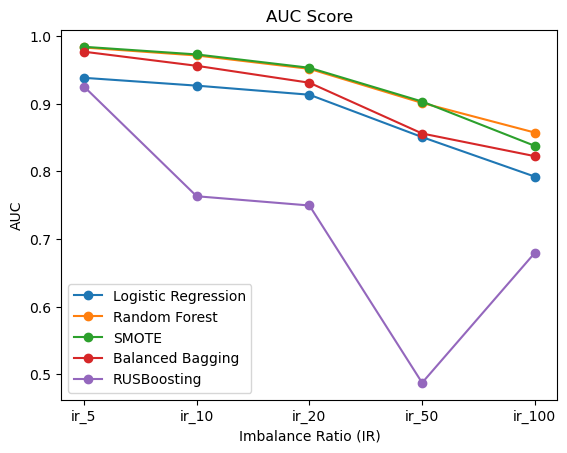

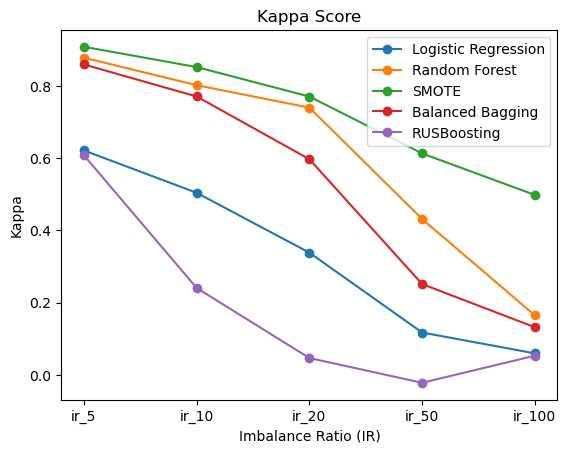

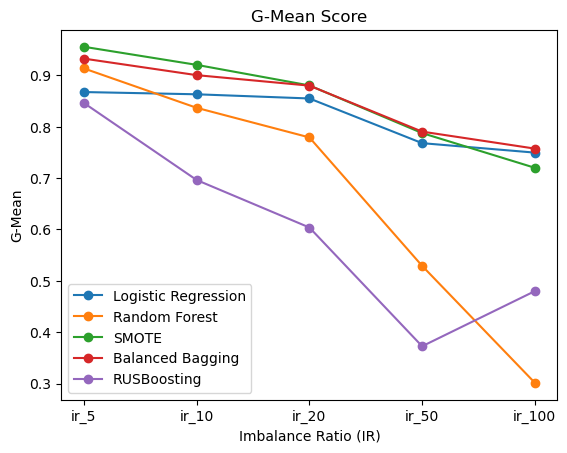

In [95]:
ir_levels = ["ir_5", "ir_10", "ir_20", "ir_50", "ir_100"]
metrics = ["AUC", "Kappa", "G-Mean"]
models = merged_result["Model"].unique()

for metric in metrics:
    for model in models:
        subset = merged_result[merged_result["Model"] == model]
        plt.plot(ir_levels, subset[metric], label=model, marker='o')
    plt.title(f"{metric} Score")
    plt.xlabel("Imbalance Ratio (IR)")
    plt.ylabel(metric)
    plt.legend()
    plt.show()

In [96]:
filtered_result = merged_result.melt(id_vars=["Dataset", "Model"], var_name="Metric", value_name="Score")
result_table = filtered_result.pivot_table(index=["Metric", "Dataset"], columns="Model", values="Score")*100
result_table = result_table.reindex(sort_order, level="Dataset")
result_table.round(2)

Model           Balanced Bagging  Logistic Regression  RUSBoosting  \
Metric Dataset                                                       
AUC    ir_5                97.71                93.85        92.56   
       ir_10               95.62                92.69        76.33   
       ir_20               93.12                91.35        74.96   
       ir_50               85.61                85.08        48.74   
       ir_100              82.26                79.23        67.96   
G-Mean ir_5                93.27                86.76        84.62   
       ir_10               90.05                86.32        69.63   
       ir_20               88.01                85.51        60.38   
       ir_50               79.05                76.81        37.26   
       ir_100              75.74                74.96        48.00   
Kappa  ir_5                85.89                62.11        60.75   
       ir_10               77.03                50.39        24.05   
       ir_20               59.67                33.82         4.66   
       ir_50               25.13                11.73        -2.18   
       ir_100              13.19                 5.96         5.31   

Model           Random Forest  SMOTE  
Metric Dataset                        
AUC    ir_5             98.33  98.44  
       ir_10            97.15  97.30  
       ir_20            95.17  95.33  
       ir_50            90.13  90.34  
       ir_100           85.74  83.78  
G-Mean ir_5             91.35  95.57  
       ir_10            83.68  92.05  
       ir_20            77.92  88.04  
       ir_50            52.92  78.77  
       ir_100           30.15  72.01  
Kappa  ir_5             87.75  90.79  
       ir_10            80.16  85.17  
       ir_20            73.95  77.02  
       ir_50            43.13  61.28  
       ir_100           16.46  49.79

#### General Observation

##### Performance Decreases with Higher Imbalance Ratios (IR):

As the IR increases, which indicates that the dataset becomes more imbalanced, the performance metrics (AUC, Kappa, and G-Mean) generally decrease across all models. This trend highlights the challenge of handling imbalanced datasets effectively, especially when the minority class becomes increasingly underrepresented.

##### Different Models Handle Imbalance Differently:

- Models like SMOTE and Balanced Bagging tend to maintain higher performance at extreme imbalance levels compared to other methods like RUSBoosting or Logistic Regression.

- RUSBoosting shows a steep decline in performance metrics as the imbalance ratio increases, especially for Kappa and G-Mean, indicating that it struggles with highly imbalanced datasets.



#### Metric-wise insights

##### AUC (Area Under the ROC Curve)

* SMOTE consistently performs the best across all IR levels, maintaining the highest AUC values, even at extreme imbalance ratios.

* Random Forest and Bagging also perform well, with Random Forest maintaining strong AUC values at moderate imbalance levels.

* RUSBoosting and Logistic Regression show significant drops in AUC as the imbalance ratio increases, indicating that they are less robust to class imbalance.

##### Kappa

* Kappa reflects the agreement between predicted and actual classifications, and it drops sharply as IR increases for all models.

* SMOTE and BalancedBagging outperform other models, especially at higher IR levels, suggesting they are better at balancing class predictions.

* RUSBoosting and Logistic Regression struggle the most, with Kappa values approaching zero at higher imbalance levels, indicating poor minority class predictions.

##### G-Mean

* G-Mean measures the balance between sensitivity and specificity. Like Kappa, it decreases significantly with higher imbalance ratios.

* SMOTE consistently maintains the highest G-Mean values across all IR levels, followed by Balanced Bagging.

* RUSBoosting and Random Forest exhibit steeper declines in G-Mean, particularly at higher IR levels, indicating that they may fail to maintain a good trade-off between true positive and true negative rates.

#### Findings regarding algorithm used

* SMOTE consistently outperforms other models across all metrics and imbalance levels, demonstrating its effectiveness in handling imbalanced datasets by synthetically augmenting the minority class. It maintains relatively stable performance, even at extreme imbalance ratios.

* Balanced Bagging performs well, particularly for G-Mean and Kappa, but shows slightly lower AUC values compared to SMOTE. It remains a strong contender, especially at moderate imbalance levels.

* Random Forest performs well for AUC but struggles to maintain high Kappa and G-Mean scores as the imbalance ratio increases. This suggests it is moderately effective but may not adequately balance minority class predictions.

* Logistic Regression shows a steady decline across all metrics as the IR increases, indicating its limitations in handling imbalanced datasets without additional techniques like SMOTE.

* RUSBoosting performs the worst at extreme imbalance levels, with dramatic drops in Kappa and G-Mean. This suggests it struggles to identify the minority class effectively in highly imbalanced datasets.

To conclude, SMOTE, combined with Random Forest is the best-performing algorithm for handling imbalanced datasets across all metrics and IR levels. It consistently maintains high AUC, Kappa, and G-Mean, making it an ideal choice when dealing with severe class imbalance. However, Balanced Bagging is also a strong alternative, particularly at moderate imbalance levels, where it maintains good performance.

## Conclusion

The analysis demonstrates that the performance of all models deteriorates as the imbalance ratio increases, reflecting the inherent difficulty in dealing with highly imbalanced datasets. Among the evaluated models, SMOTE consistently outperforms others across all metrics and IR levels, making it the most reliable choice for handling severe class imbalance. Balanced Bagging also shows strong performance, particularly for G-Mean and Kappa, positioning it as a viable alternative for moderately imbalanced datasets. In contrast, RUSBoosting and Logistic Regression struggle to maintain their effectiveness, with significant declines in performance at higher IR levels. 

The findings of this report underscores the importance of selecting suitable models and incorporating preprocessing techniques like SMOTE (oversampling) or undersampling when addressing imbalanced datasets. Overall, the findings highlight the critical role of evaluating models on multiple metrics to ensure balanced and effective predictions in imbalanced learning scenarios.